### ## BBM 409 - Programming Assignment 2

* You can add as many cells as you want in-between each question.
* Please add comments to your code to explain your work.  

* Please be careful about the order of runs of cells. Doing the homework, it is likely that you will be running the cells in different orders, however, they will be evaluated in the order they appear. Hence, please try running the cells in this order before submission to make sure they work.    
* Please refer to the homework text for any implementation detail. You should also carefully review the steps explained here.
* This document is also your report. Show your work.

##  Yusuf, Küçüköner, 2210356092

# 1. LOGISTIC REGRESSION TASK (40 points)

### 1. Data Loading and Exploration

##### Download the Bank Marketing dataset from https://drive.google.com/file/d/1t6QAtqfYLMhvv_XUnG4D_UsJcSwgF4an/view?usp=sharing  import other necessary libraries

In [369]:
#do the necessary imports for ml project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC



In [370]:
df=pd.read_csv("./portuguese_bank_marketing_numeric_random_subsampled.csv", encoding="utf-8")

Lets check the metadata of the data to see if there are any null values etc.

In [371]:
#check the metadata null values etc.
print(df.info())
print(df.describe())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10578 entries, 0 to 10577
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          10578 non-null  int64  
 1   job          10578 non-null  float64
 2   marital      10578 non-null  int64  
 3   education    10578 non-null  float64
 4   default      10578 non-null  int64  
 5   balance      10578 non-null  int64  
 6   housing      10578 non-null  int64  
 7   loan         10578 non-null  int64  
 8   contact      10578 non-null  float64
 9   day_of_week  10578 non-null  int64  
 10  month        10578 non-null  int64  
 11  duration     10578 non-null  int64  
 12  campaign     10578 non-null  int64  
 13  pdays        10578 non-null  int64  
 14  previous     10578 non-null  int64  
 15  poutcome     10578 non-null  float64
 16  y            10578 non-null  int64  
dtypes: float64(4), int64(13)
memory usage: 1.4 MB
None
                age           job    

Now lets float values if they really needed as float or we can simply use integer which is way more easy to work with.

In [372]:
print(df['job'].value_counts())
print(df['contact'].value_counts())
print(df['poutcome'].value_counts())
print(df['education'].value_counts())
print(df['y'].value_counts())



job
1.0     2367
4.0     1940
2.0     1736
6.0     1229
7.0      859
5.0      749
9.0      365
8.0      354
11.0     350
3.0      287
10.0     275
0.0       67
Name: count, dtype: int64
contact
1.0    7639
0.0    2199
2.0     740
Name: count, dtype: int64
poutcome
0.0    7866
1.0    1139
3.0    1048
2.0     525
Name: count, dtype: int64
education
2.0    5215
3.0    3466
1.0    1438
0.0     459
Name: count, dtype: int64
y
1    5289
2    5289
Name: count, dtype: int64


In [373]:
# Turning floats to integers since there are nothing to do with float.
df['job'] = df['job'].astype('category').cat.codes
df['contact'] = df['contact'].astype('category').cat.codes
df['poutcome'] = df['poutcome'].astype('category').cat.codes
df['education'] = df['education'].astype('category').cat.codes

# And also turning the target variable to binary for simplicity.
df['y'] = df['y'].replace(1,0)
df['y'] = df['y'].replace(2,1)


Now lets gain a insight on data distribution.

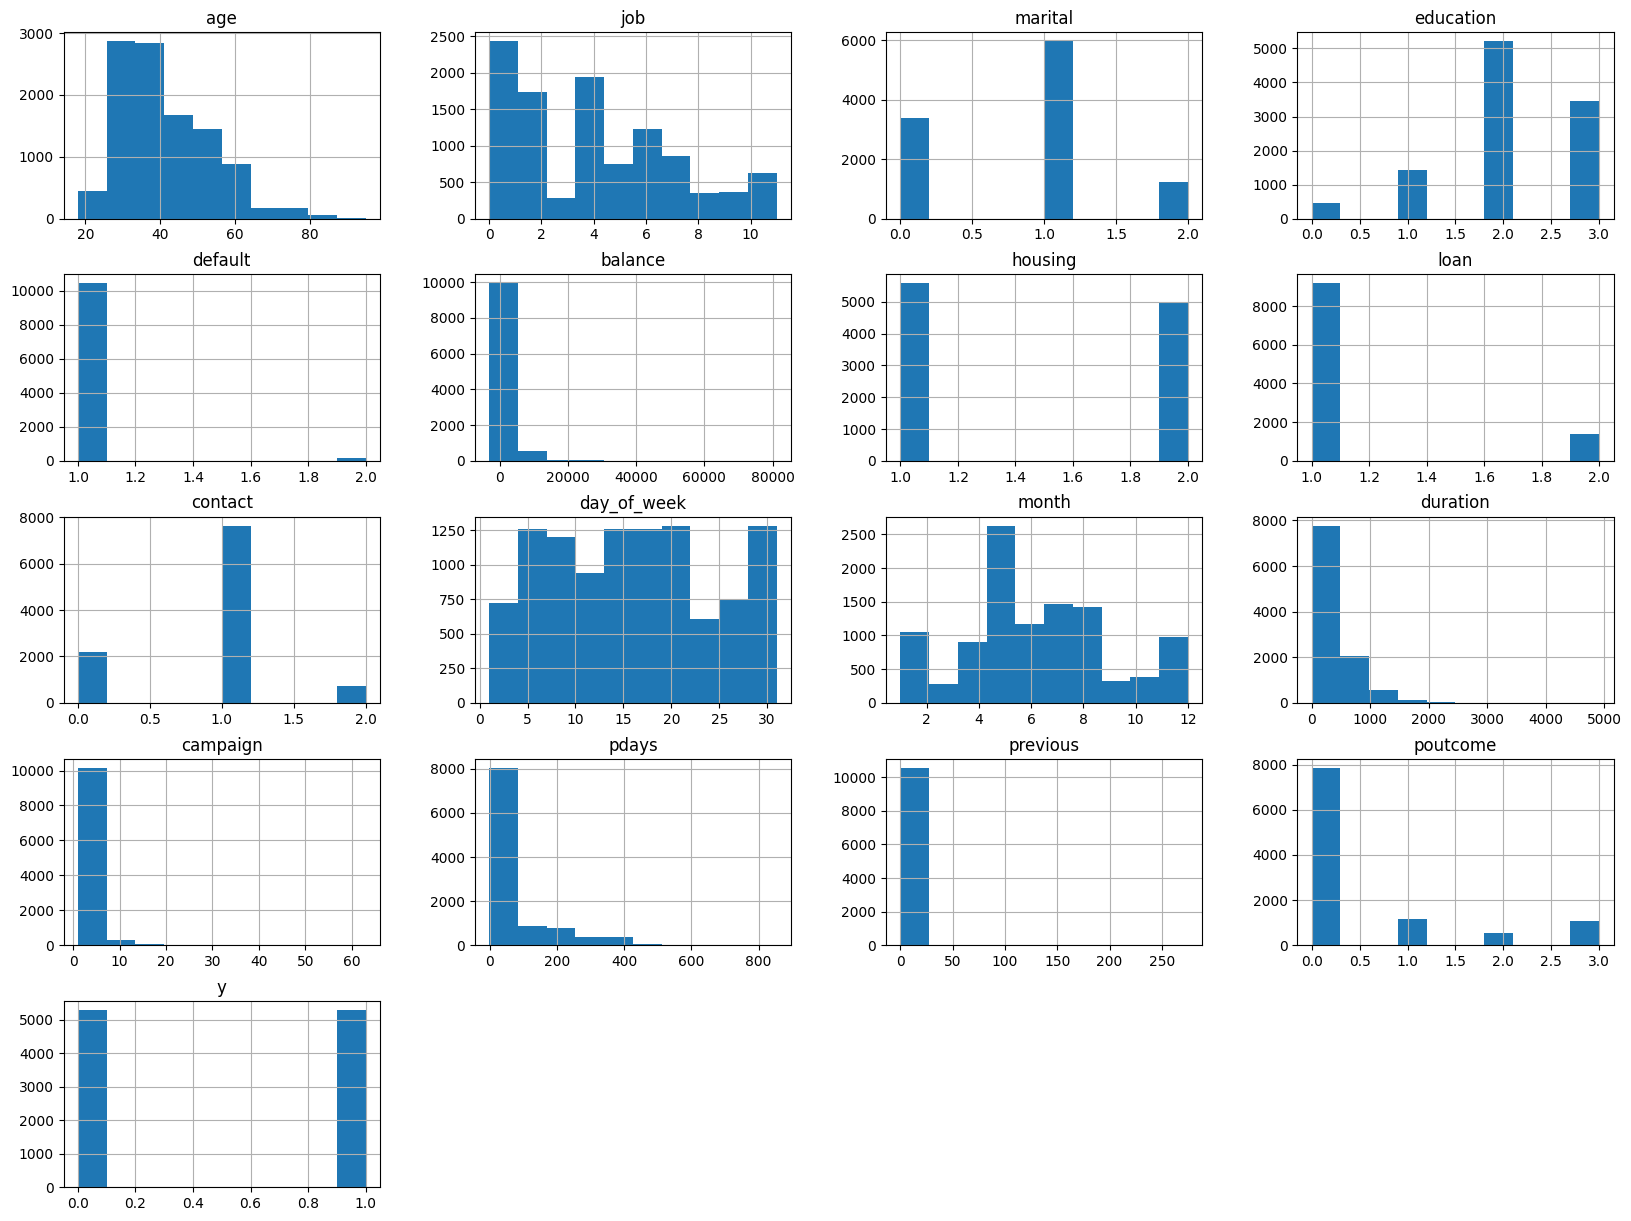

In [374]:
df.hist(bins=10, figsize=(20,15))
plt.show()



#### Based on the data distribution it is clear that dataset needs a normalization process.

### 2. calculate correlation between target variable 'y' and other features (5 points)

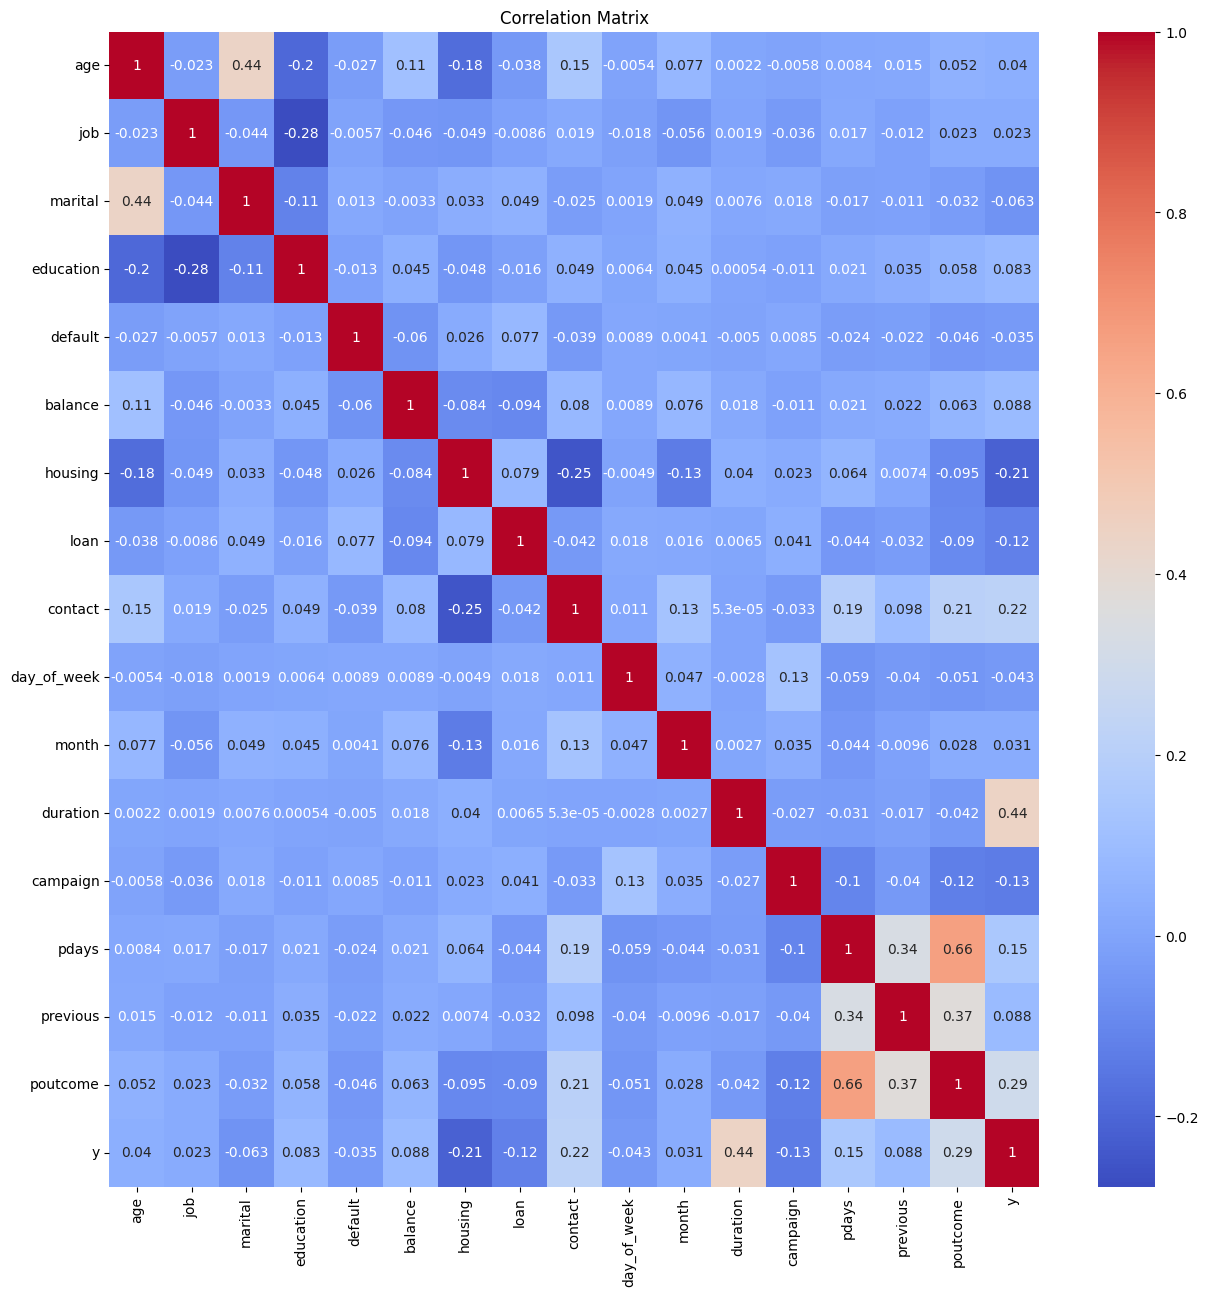

In [375]:
# To see correlation between any variable to any other variable we can use the correlation matrix method.
corr_matrix=df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# 1.1 Implementing Logistic Regression with most correlated 2 features

###  Choose the two most correlated features with target feature 'y'

In [376]:
# The correlation matrix shows that duration and poutcome are the most correlated variables with the target variable. 
X=df[['duration', 'poutcome']] # We will use these two variables for our model.
y=df['y']

print(X.head())
print(y.tail())


   duration  poutcome
0       196         0
1       110         0
2       378         0
3       358         0
4        88         0
10573    1
10574    1
10575    1
10576    1
10577    1
Name: y, dtype: int64


###  * Define your logistic regression model as class without using any built-in libraries
### * Define necessary functions such as sigmoid, fit, predict  (10 points)

In [377]:
def sigmoid(z): # Basically a probability function of the output.(How much we are sure about the output)
    return 1 / (1 + np.exp(-z))

def predict(features, weights, bias):
    z = np.dot(features, weights) + bias
    return sigmoid(z)

def cost_function(features, labels, weights, bias): # Not needed but for the sake of understanding the cost function.
    observations = len(labels)
    predictions = predict(features, weights, bias)
    class1_cost = -labels * np.log(predictions)
    class2_cost = - (1 - labels) * np.log(1 - predictions)
    cost = class1_cost + class2_cost
    cost = cost.sum() / observations
    return cost

def update_weights(features, labels, weights, bias, lr): # Updating the weights and bias with the help of gradient descent.
    predictions = predict(features, weights, bias)
    gradient = np.dot(features.T, predictions - labels) / len(labels)
    bias_gradient = np.sum(predictions - labels) / len(labels)
    
    weights -= lr * gradient
    bias -= lr * bias_gradient
    return weights, bias


Creating fit function and checking cost in each 100 iteration to see if it is decreasing or not. It will give us a good insight about if model working correctly or not.

In [378]:
def fit(features, labels, weights, bias, lr, iters):
    for i in range(iters):
        weights, bias = update_weights(features, labels, weights, bias, lr)
        if i % 100 == 0:
            cost = cost_function(features, labels, weights, bias)
            print(f"Iteration {i}: Cost {cost}") # To see the cost function in every 100 iterations to see progress.
    return weights, bias


Split the dataset into a training set and a validation set (80% training and 20% validation).

In [379]:
# Using the sklearn's train_test_split method to split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8462, 2)
(2116, 2)
(8462,)
(2116,)


Scale the features using StandardScaler

In [380]:
# Doing Z-score normalization to scale the data.
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

* Initialize and train the custom logistic regression model

In [381]:
# Initializing the weights and bias with random values. Trying and finding optimal learning rate.
weights = np.random.rand(X_train.shape[1])
bias = np.random.rand(1)
lr = 0.01
iters = 1000
weights, bias = fit(X_train, y_train, weights, bias, lr, iters)


Iteration 0: Cost 0.6183246359968376
Iteration 100: Cost 0.5864412950795401
Iteration 200: Cost 0.5652585798875146
Iteration 300: Cost 0.550533752532188
Iteration 400: Cost 0.5399193493362348
Iteration 500: Cost 0.5320399089840072
Iteration 600: Cost 0.5260475064828073
Iteration 700: Cost 0.5213970320402079
Iteration 800: Cost 0.5177256158786671
Iteration 900: Cost 0.5147844584493457


* Make predictions on the validation set

In [382]:
# Predicting the test set and rounding the values to 0 and 1.
predictions = predict(X_test, weights, bias)
predictions = [1 if i > 0.5 else 0 for i in predictions]
print(predictions) # Predictions


[1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 

### Evaluate the model's performance, print classification report and confusion matrix  (5 points)

In [383]:
# Classification report and confusion matrix to see the performance of the model.
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test, predictions))

[[894 198]
 [316 708]]
              precision    recall  f1-score   support

           0       0.74      0.82      0.78      1092
           1       0.78      0.69      0.73      1024

    accuracy                           0.76      2116
   macro avg       0.76      0.76      0.76      2116
weighted avg       0.76      0.76      0.76      2116



### Interpretation of Scores and Confusion Matrix
The model correctly classifies 76% of the data overall, with slightly better precision and recall for class 1 (positive) compared to class 0 (negative). However, it struggles a bit with false negatives (classifying actual 1s as 0) and false positives (classifying actual 0s as 1).

### Print decision boundaries as in PA1 (5 points)

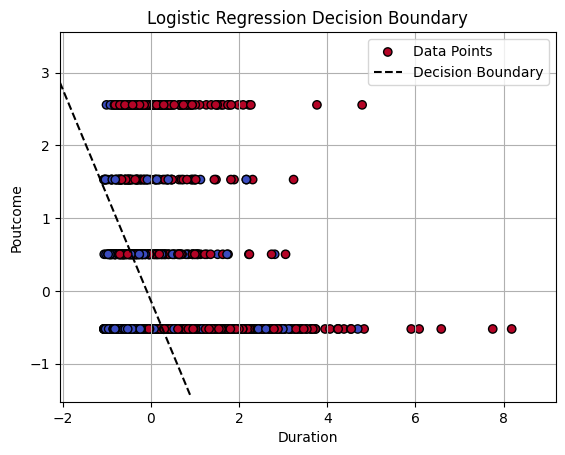

In [384]:
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundary(X, y, weights, bias):

    # Plot the data points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k', label="Data Points")
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x_vals = np.linspace(x_min, x_max, 100)
    y_vals = -(weights[0] * x_vals + bias) / weights[1]  # Decision boundary equation

    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    valid_indexes = (y_vals >= y_min) & (y_vals <= y_max)
    x_vals = x_vals[valid_indexes]
    y_vals = y_vals[valid_indexes]

    # Plot the decision boundary
    plt.plot(x_vals, y_vals, color="black", linestyle="--", label="Decision Boundary")

    # Set axis limits
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    # Add labels
    plt.xlabel("Duration")
    plt.ylabel("Poutcome")
    plt.title("Logistic Regression Decision Boundary")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_decision_boundary(X_test, y_test, weights, bias)


# 1.2 Implementing Logistic Regression using all features.





* Redefine input and target variables. In this experiment, you will use all input features in the dataset.

In [385]:
# Using the all of the features for the model.
X=df.drop('y', axis=1)
y=df['y']

* Split the dataset into a training set and a validation set (80% training and 20% validation).

In [386]:
# Splitting the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



* Scale the features using StandardScaler

In [387]:
# Z-score normalization to scale the data.
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

### Initialize and train the custom logistic regression model.

In [388]:
# Initializing the weights and bias with random values. Trying and finding optimal learning rate.
weights = np.random.rand(X_train.shape[1])
bias = np.random.rand(1)
lr = 0.01
iters = 5000
weights, bias = fit(X_train, y_train, weights, bias,lr, iters)

Iteration 0: Cost 1.0500095810660872
Iteration 100: Cost 0.8892697879770731
Iteration 200: Cost 0.7698230526330098
Iteration 300: Cost 0.682153237215785
Iteration 400: Cost 0.6183519772523133
Iteration 500: Cost 0.5723948214180311
Iteration 600: Cost 0.5395884665602558
Iteration 700: Cost 0.5161808971874847
Iteration 800: Cost 0.49930715705863776
Iteration 900: Cost 0.48693663961642913
Iteration 1000: Cost 0.4776954022980659
Iteration 1100: Cost 0.4706654037392285
Iteration 1200: Cost 0.46522894787390767
Iteration 1300: Cost 0.46096349372969775
Iteration 1400: Cost 0.45757407883426204
Iteration 1500: Cost 0.45485052854561636
Iteration 1600: Cost 0.4526402117749843
Iteration 1700: Cost 0.45083042223319736
Iteration 1800: Cost 0.44933676334600686
Iteration 1900: Cost 0.4480953461316759
Iteration 2000: Cost 0.4470574483481892
Iteration 2100: Cost 0.4461857464865217
Iteration 2200: Cost 0.4454514682217485
Iteration 2300: Cost 0.44483199952176805
Iteration 2400: Cost 0.4443088286635808
Iter

* Make predictions on the validation set

In [389]:
# Predicting the test set and rounding the values to 0 and 1.
y_pred = predict(X_test, weights,bias)
y_pred = [1 if i >= 0.5 else 0 for i in y_pred]

### Evaluate the model's performance, print classification report and confusion matrix  (5 points)

In [390]:
# Classification report and confusion matrix to see the performance of the model.
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.81      0.80      1092
           1       0.79      0.78      0.79      1024

    accuracy                           0.80      2116
   macro avg       0.80      0.79      0.80      2116
weighted avg       0.80      0.80      0.80      2116

[[884 208]
 [225 799]]


### Briefly explain the impact of the number of features on the learning ability of the model. (5 points)

Increasing the number of features can enhance a model's ability to capture more detailed patterns in the data, leading to improved performance and more accurate predictions, as the model has access to more relevant information for decision-making. However, if irrelevant features are added, it can lead to overfitting, where the model memorizes noise instead of generalizing well to new data.

### After completing the SVM and logistic regression tasks, the best results of the experiments with the SVM and Logistic regression models will be compared in a table. (5 points)

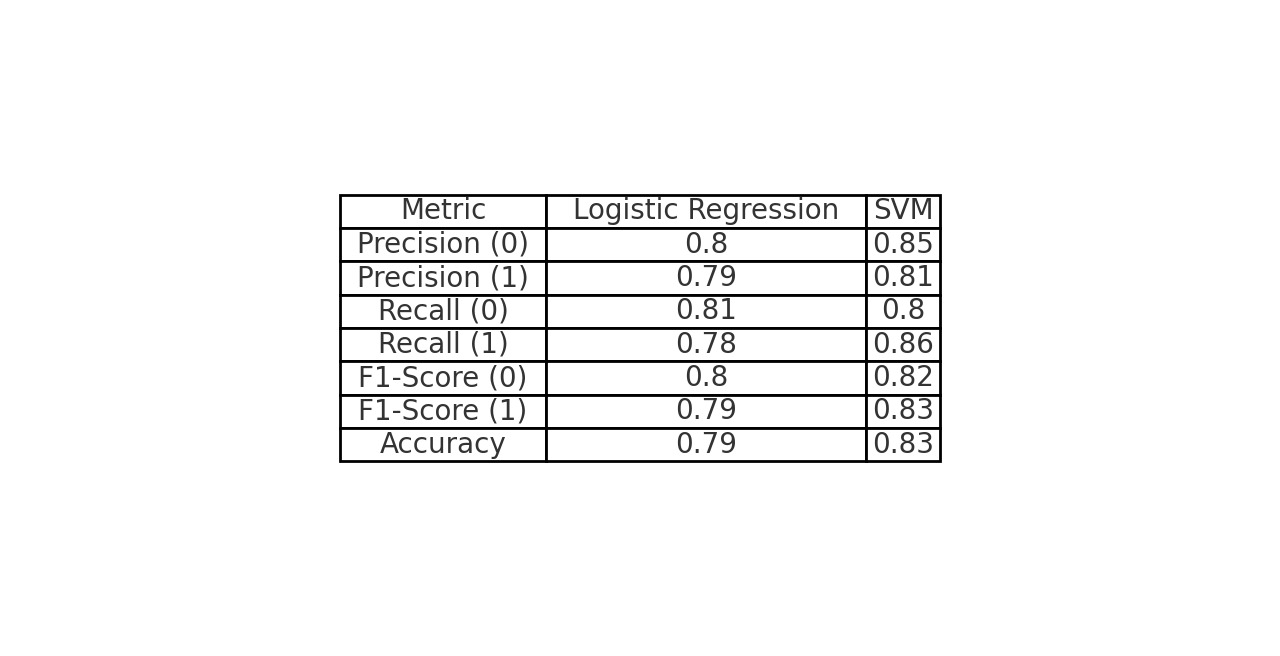

# Model Comparison: Logistic Regression vs. SVM

## 1. Precision:
- **Class 0**:  
  - **SVM**: 0.85  
  - **Logistic Regression**: 0.80  
  **Conclusion**: SVM makes fewer false positive errors for Class 0, meaning it's more confident when predicting this class.  
  *This indicates that SVM is better at identifying Class 0 samples correctly while avoiding incorrectly classifying other samples as Class 0.*

- **Class 1**:  
  - **SVM**: 0.81  
  - **Logistic Regression**: 0.79  
  **Conclusion**: SVM slightly outperforms Logistic Regression in reducing false positives for Class 1.  
  *This suggests that SVM is better at identifying Class 1 samples while minimizing the misclassification of non-Class 1 samples.*

---

## 2. Recall:
- **Class 0**:  
  - **Logistic Regression**: 0.81  
  - **SVM**: 0.80  
  **Conclusion**: Logistic Regression identifies more actual Class 0 samples, with fewer false negatives.  
  *This means Logistic Regression does a slightly better job of capturing all Class 0 samples, avoiding missed detections.*

- **Class 1**:  
  - **SVM**: 0.86  
  - **Logistic Regression**: 0.78  
  **Conclusion**: SVM is significantly better at capturing all Class 1 samples, reducing missed cases.  
  *This shows that SVM is more effective at identifying all true Class 1 instances, ensuring fewer false negatives.*

---

## 3. F1-Score:
- **Class 0**:  
  - **SVM**: 0.82  
  - **Logistic Regression**: 0.80  
  **Conclusion**: SVM achieves a better balance between precision and recall for Class 0.  
  *This indicates that SVM maintains a more balanced approach between correctly identifying Class 0 samples and minimizing false negatives and positives.*

- **Class 1**:  
  - **SVM**: 0.83  
  - **Logistic Regression**: 0.79  
  **Conclusion**: SVM handles Class 1 predictions more effectively by balancing precision and recall.  
  *SVM's higher F1-score for Class 1 means it does a better job of both correctly identifying Class 1 samples and avoiding misclassifications.*

---

## 4. Accuracy:
- **SVM**: 0.83  
- **Logistic Regression**: 0.79  
**Conclusion**: SVM classifies a higher proportion of total samples correctly.  
*This shows that SVM has a higher overall performance in terms of classifying both classes correctly, providing a more reliable prediction across the entire dataset.*

---

## Overall Conclusion:
- **SVM** is better for scenarios where reducing false negatives (Class 1 recall) and overall accuracy are priorities.  
  *This means that if Class 1 is more important to identify correctly, SVM is the better choice, as it captures more Class 1 samples and has better overall accuracy.*
  
- Logistic Regression is a simpler model and performs decently but is less effective for Class 1 predictions.  
  *While Logistic Regression is easier to implement and still provides a solid performance, it falls short in identifying Class 1 samples compared to SVM, making it less suitable for cases where Class 1 is critical.*


# 2. Support Vector Machine Task  (30 points)

* Define your SVM model using sklearn

## 2.1 implementing svm with grid search cv using all features (10 points)

* Define features and target variable, you will use all features of dataset in this task

In [391]:
# Dropping y column to get the features.
X=df.drop('y', axis=1)
y=df['y']

* Split the dataset into a training set and a validation set (80% training and 20% validation).

In [392]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

* Scale the features using StandardScaler

In [393]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

#### Implement GridSearchCV  (5 points)

In [394]:
# Finding the best parameters for the model using sklearn GridSearchCV.

# To reduce the time complexity of the GridSearchCV, we can use a subset of the data.
X_train=X_train[:2000]
y_train=y_train[:2000]


# Defining the parameters for the GridSearchCV.

param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)
grid.fit(X_train, y_train)

best_params=grid.best_params_ # Best parameters for the model we are gonna use this parameters for the svm.

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.507 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.507 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.507 total time=   0.1s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.507 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.507 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.767 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.790 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.780 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.820 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.800 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.795 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.757 total time=   0.0s
[CV 3/5] END .....C=0.1, gam

* Initialize the SVM classifier using the parameters we gained through GridSearchCV because those parameters will give the best result for the data.

In [395]:
# Using the best parameters for the model.
svm=SVC(**best_params)

* Train the SVM classifier with the best parameters found from grid search


In [396]:
# Now we can fit the model with the training data.
svm.fit(X_train, y_train)


SVC(C=1, gamma=0.1)

* Make predictions on the validation set using the best model


In [397]:
# Predicting the test set.
y_pred = svm.predict(X_test)


#### Evaluate the model's performance, print classification report and confusion matrix and best parameters found from GridSearchCV  (5 points)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.80      0.82      1065
           1       0.81      0.86      0.83      1051

    accuracy                           0.83      2116
   macro avg       0.83      0.83      0.83      2116
weighted avg       0.83      0.83      0.83      2116

[[851 214]
 [149 902]]
{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=1, gamma=0.1)


## 2.2 implementing svm with most correlated 2 features (10 points)

#### Choose the two most correlated features with target feature 'y'

In [399]:
# In before we already determined the most correlated variables with the target variable.
X=df[['duration', 'poutcome']]
y=df['y']


* Split the dataset into a training set and a validation set (80% training and 20% validation).

In [400]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

* Scale the features using StandardScaler

In [401]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)


*  Initialize the SVM classifier, assign 'C' and 'kernel' parameters from the best hyperparameters you found from GridSearchCV

In [402]:
svm=SVC(**best_params)

* Train the SVM classifier

In [403]:
svm.fit(X_train, y_train)

SVC(C=1, gamma=0.1)

* Make predictions on the validation set

In [404]:
# Predicting the test set.
y_pred = svm.predict(X_test)

#### Evaluate the model's performance, print classification report and confusion matrix  (5 points)

In [405]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.79      0.77      1092
           1       0.77      0.73      0.75      1024

    accuracy                           0.76      2116
   macro avg       0.76      0.76      0.76      2116
weighted avg       0.76      0.76      0.76      2116

[[863 229]
 [275 749]]


##### Visualize decision boundary and support vectors (5 points)

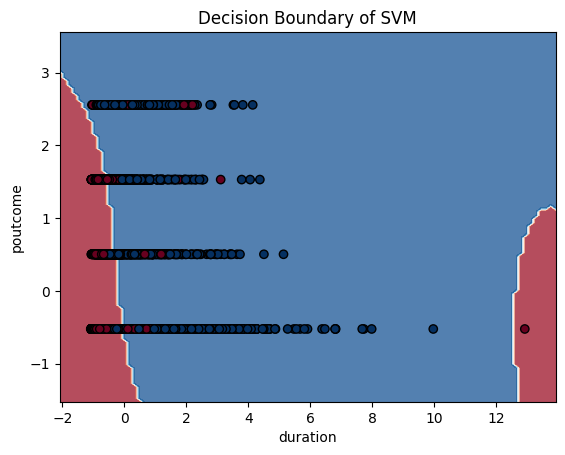

In [406]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

def plot_svm_decision_boundary(X_train, y_train, model,feature1, feature2):
    # Determine the min and max values of the features
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

    # Generate a grid of points to evaluate the decision function within the feature range
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    # Predict over the grid points using the model
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.RdBu)

    # Plot the training points
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.RdBu, marker='o')

    plt.title("Decision Boundary of SVM")
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.xlim(x_min, x_max)  # Limit x-axis to data range
    plt.ylim(y_min, y_max)  # Limit y-axis to data range
    plt.show()

plot_svm_decision_boundary(X_train, y_train, svm, 'duration', 'poutcome')



## 2.3 implementing svm with least correlated 2 features (10 points)

#### Choose the two least correlated features with target feature 'y'

In [407]:
# Using the age and job features for the model.
X=df[['age', 'job']]
y=df['y']


* Split the dataset into a training set and a validation set (80% training and 20% validation).

In [408]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  

* Scale the features using StandardScaler

In [409]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)


*  Initialize the SVM classifier, assign 'C' and 'kernel' parameters from the best hyperparameters you found from GridSearchCV

In [410]:
svm=SVC(**best_params)

* Train the SVM classifier

In [411]:
svm.fit(X_train, y_train)

SVC(C=1, gamma=0.1)

* Make predictions on the validation set

In [412]:
y_pred = svm.predict(X_test)


#### Evaluate the model's performance, print classification report and confusion matrix  (5 points)

In [413]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[670 422]
 [512 512]]
              precision    recall  f1-score   support

           0       0.57      0.61      0.59      1092
           1       0.55      0.50      0.52      1024

    accuracy                           0.56      2116
   macro avg       0.56      0.56      0.56      2116
weighted avg       0.56      0.56      0.56      2116



##### Visualize decision boundary and support vectors(5 points)

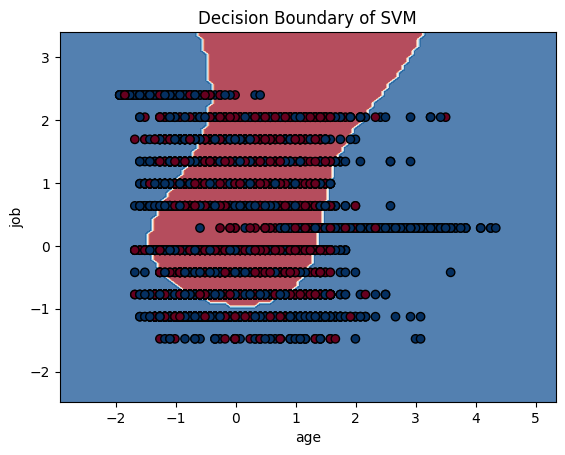

In [414]:
plot_svm_decision_boundary(X_train, y_train, svm, 'age', 'job')

# 3. Decision Tree Task (30 points)

* Define your decision tree model using sklearn. Also you should define other necessary modules for visualize the decision tree

### Download the dataset from https://drive.google.com/file/d/1D3peA-TzIqJqZDDKTlK0GQ7Ya6FIemFv/view?usp=sharing

### import other necessary libraries

In [415]:
df=pd.read_csv("./weights_bmi_6classes_updated.csv", encoding="utf-8")

In [416]:
#Check the metadata null values etc.
print(df.info())
print(df.describe())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360 entries, 0 to 3359
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   BMI_CLASS       3360 non-null   int64  
 1   UNIT_NUM        3360 non-null   int64  
 2   STUB_NAME_NUM   3360 non-null   int64  
 3   STUB_LABEL_NUM  3360 non-null   float64
 4   YEAR_NUM        3360 non-null   int64  
 5   AGE_NUM         3360 non-null   float64
 6   ESTIMATE        3360 non-null   float64
 7   SE              3360 non-null   float64
 8   FLAG            3360 non-null   int64  
dtypes: float64(4), int64(5)
memory usage: 236.4 KB
None
         BMI_CLASS     UNIT_NUM  STUB_NAME_NUM  STUB_LABEL_NUM     YEAR_NUM  \
count  3360.000000  3360.000000    3360.000000     3360.000000  3360.000000   
mean      3.500000     1.607143       4.142857        3.966964     5.500000   
std       1.708079     0.488458       1.328846        1.470850     2.872709   
min       1.000000     1.0

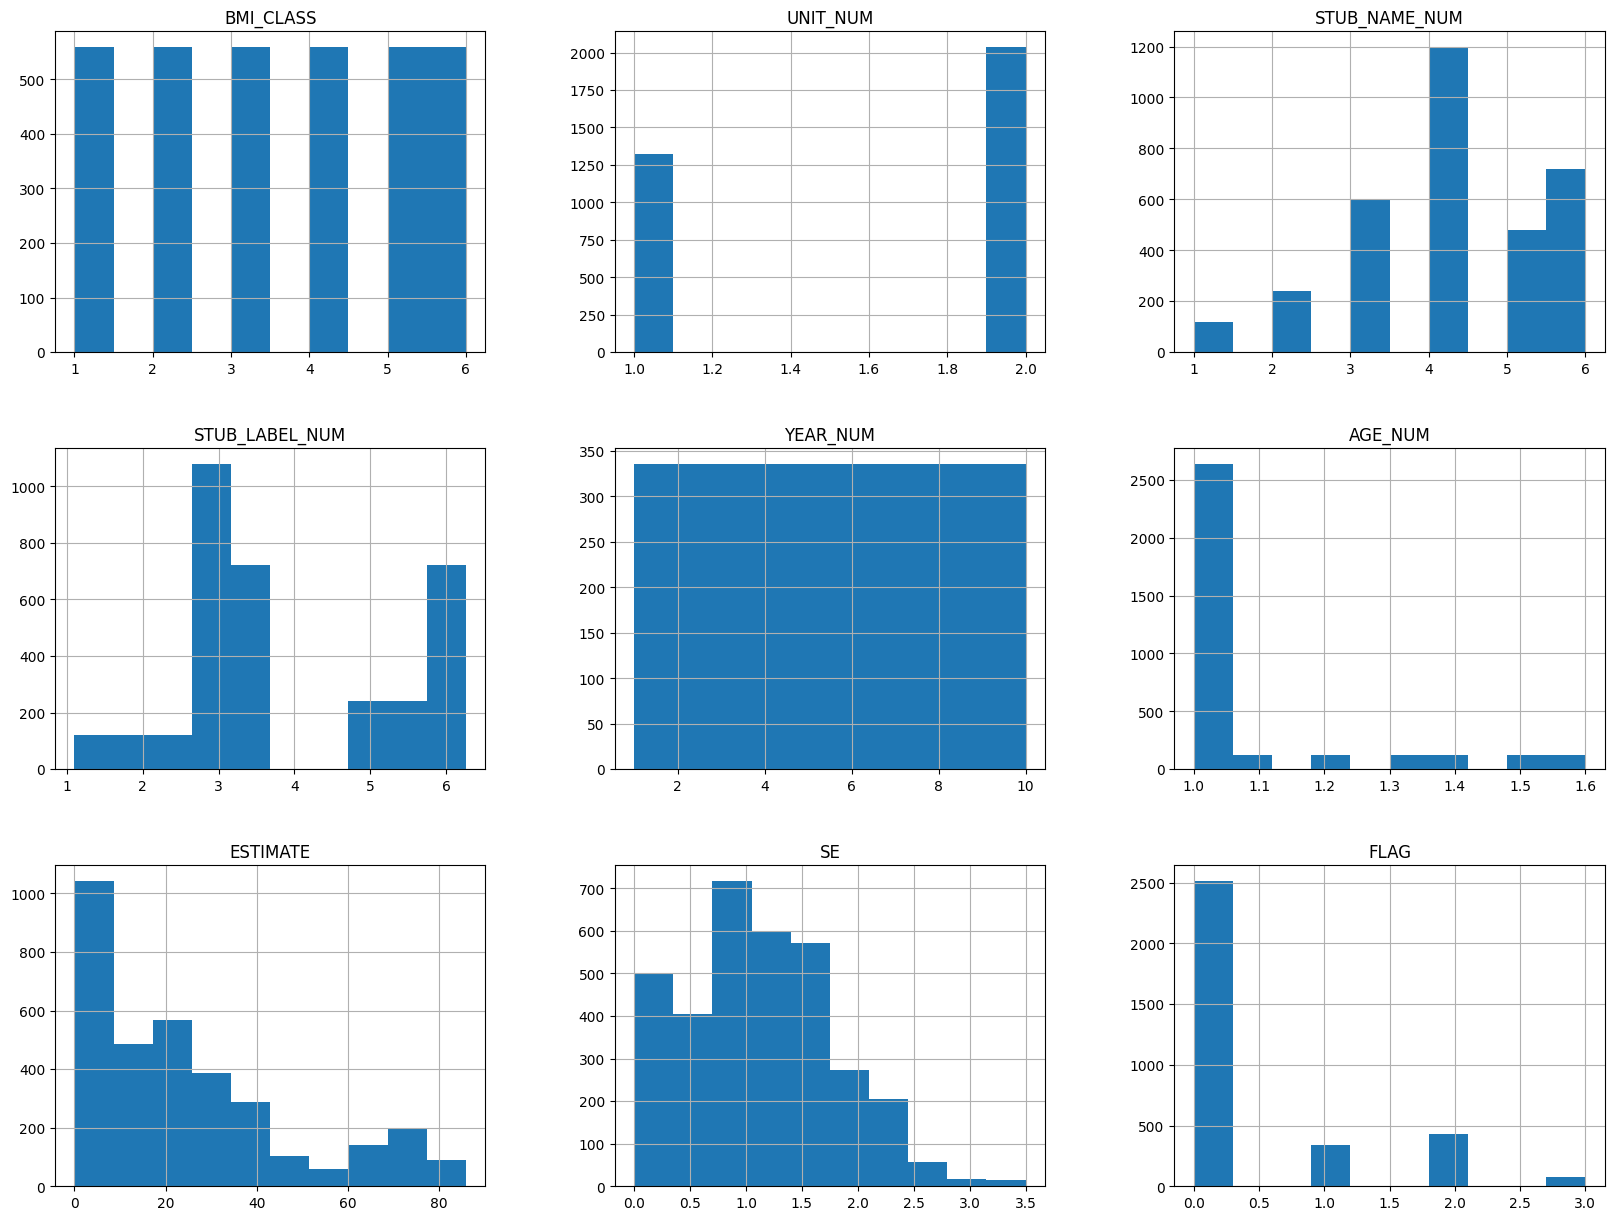

In [417]:
df.hist(bins=10, figsize=(20,15))
plt.show()


* Define features and target variable, you will use all features of dataset in this task

In [418]:
X= df.drop('BMI_CLASS', axis=1)
y = df['BMI_CLASS']

* Split the dataset into a training set and a validation set (80% training and 20% validation).

In [419]:
#Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=120)


* Initialize the Decision Tree classifier

In [420]:
#Initialize the decision tree classifier
from sklearn.tree import DecisionTreeClassifier
# add impurity
dt = DecisionTreeClassifier(min_impurity_decrease=0.0001) # This is creating some prunity in the tree and actually decreases the default prunity of the tree.

# It may lead to overfitting but in this scenario it is not overfitting.




* Train the Decision Tree classifier

In [421]:
dt.fit(X_train, y_train)


DecisionTreeClassifier(min_impurity_decrease=0.0001)

* Make predictions on the validation set

In [422]:
y_pred = dt.predict(X_test)

#### Evaluate the model's performance, print classification report and confusion matrix  (10 points)

In [423]:
# Evaluate the model using classification report and confusion matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           1       0.66      0.65      0.66       107
           2       0.60      0.96      0.74       110
           3       0.88      0.72      0.79       125
           4       0.88      0.70      0.78       105
           5       0.81      0.68      0.74       110
           6       0.77      0.75      0.76       115

    accuracy                           0.75       672
   macro avg       0.77      0.75      0.75       672
weighted avg       0.77      0.75      0.75       672

[[ 70  14  12   8   2   1]
 [  4 106   0   0   0   0]
 [ 16  17  90   2   0   0]
 [ 16  12   0  74   3   0]
 [  0  11   0   0  75  24]
 [  0  16   0   0  13  86]]


#### Visualize the Decision Tree, show clearly class number, gini value etc.  (10 points)


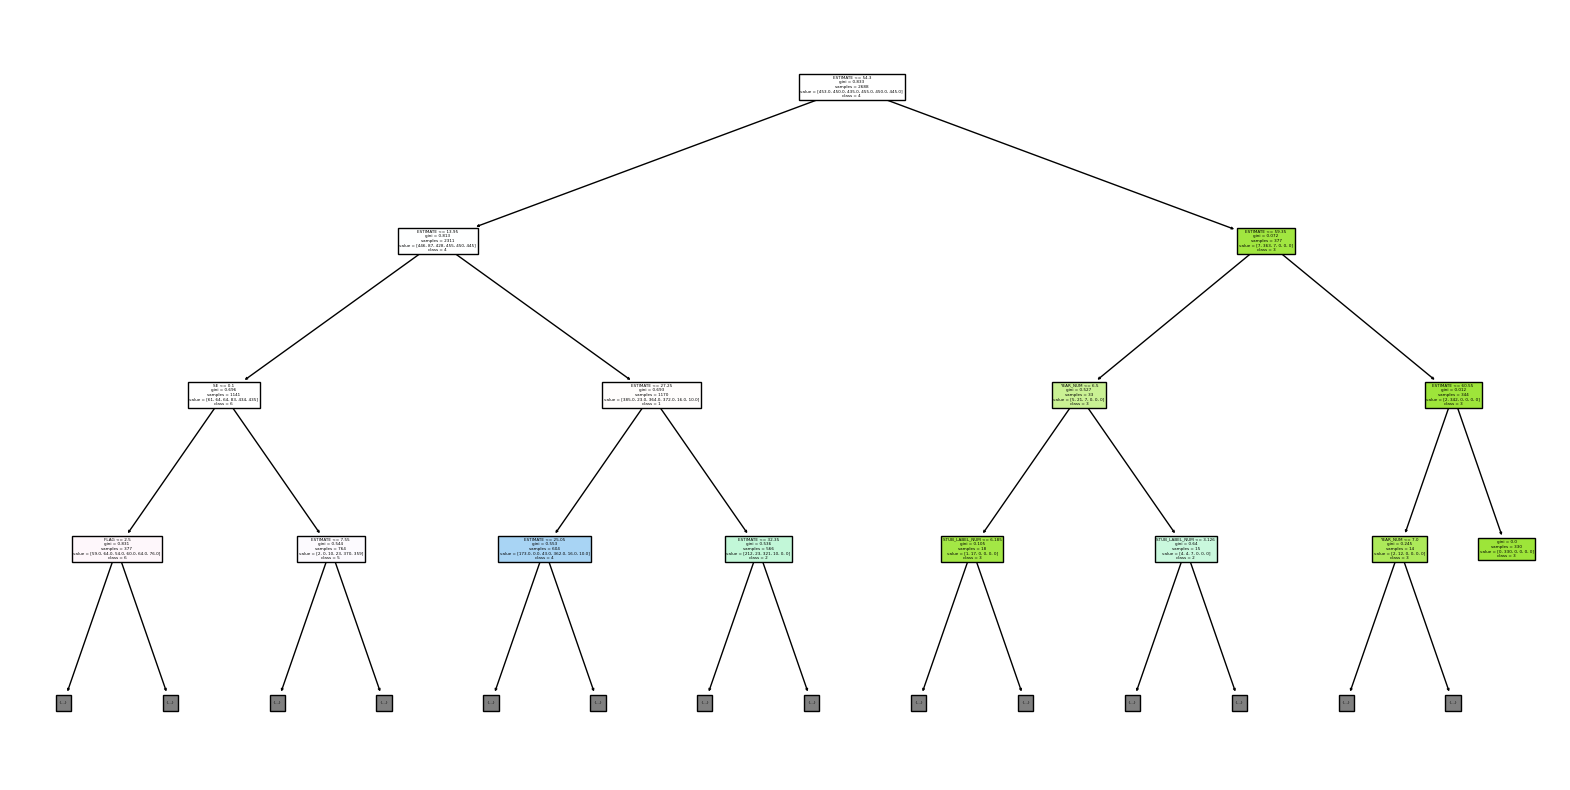

In [424]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Visualizing the decision tree limit max_depth to 3 because otherwise the plot will be too big and nothing will be visible.
plt.figure(figsize=(20, 10))
plot_tree(dt, 
          filled=True, 
          feature_names=X.columns, 
          class_names=[str(label) for label in y.unique()],
          max_depth=3)
plt.show()




Lets print the max_depth 2 tree which is visually more clear since less depth.

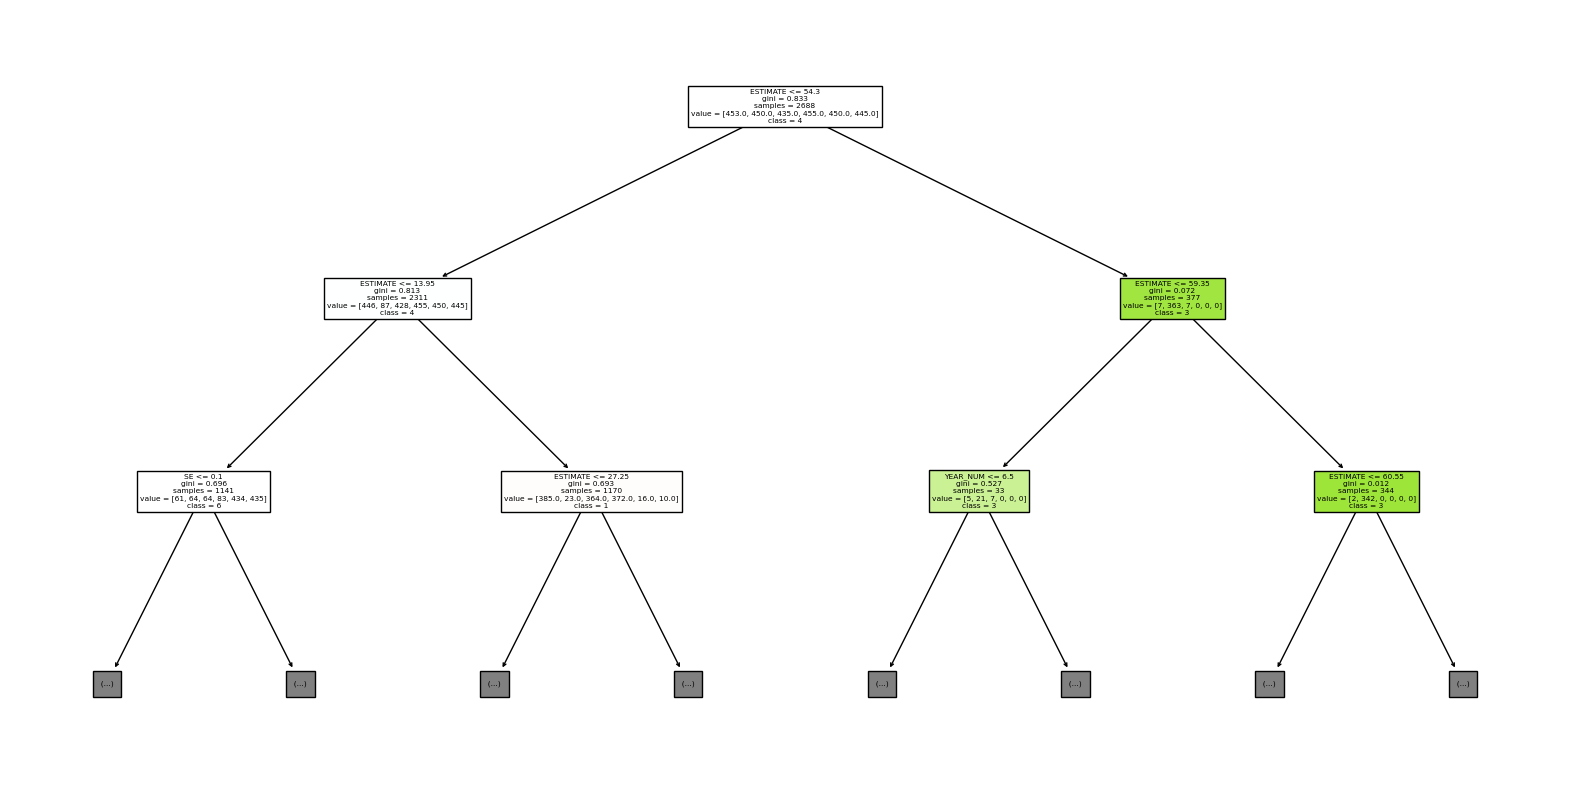

In [425]:
plt.figure(figsize=(20, 10))
plot_tree(dt, 
          filled=True, 
          feature_names=X.columns, 
          class_names=[str(label) for label in y.unique()],
          max_depth=2)
plt.show()

And print the whole tree, this is not visually interpretative. 

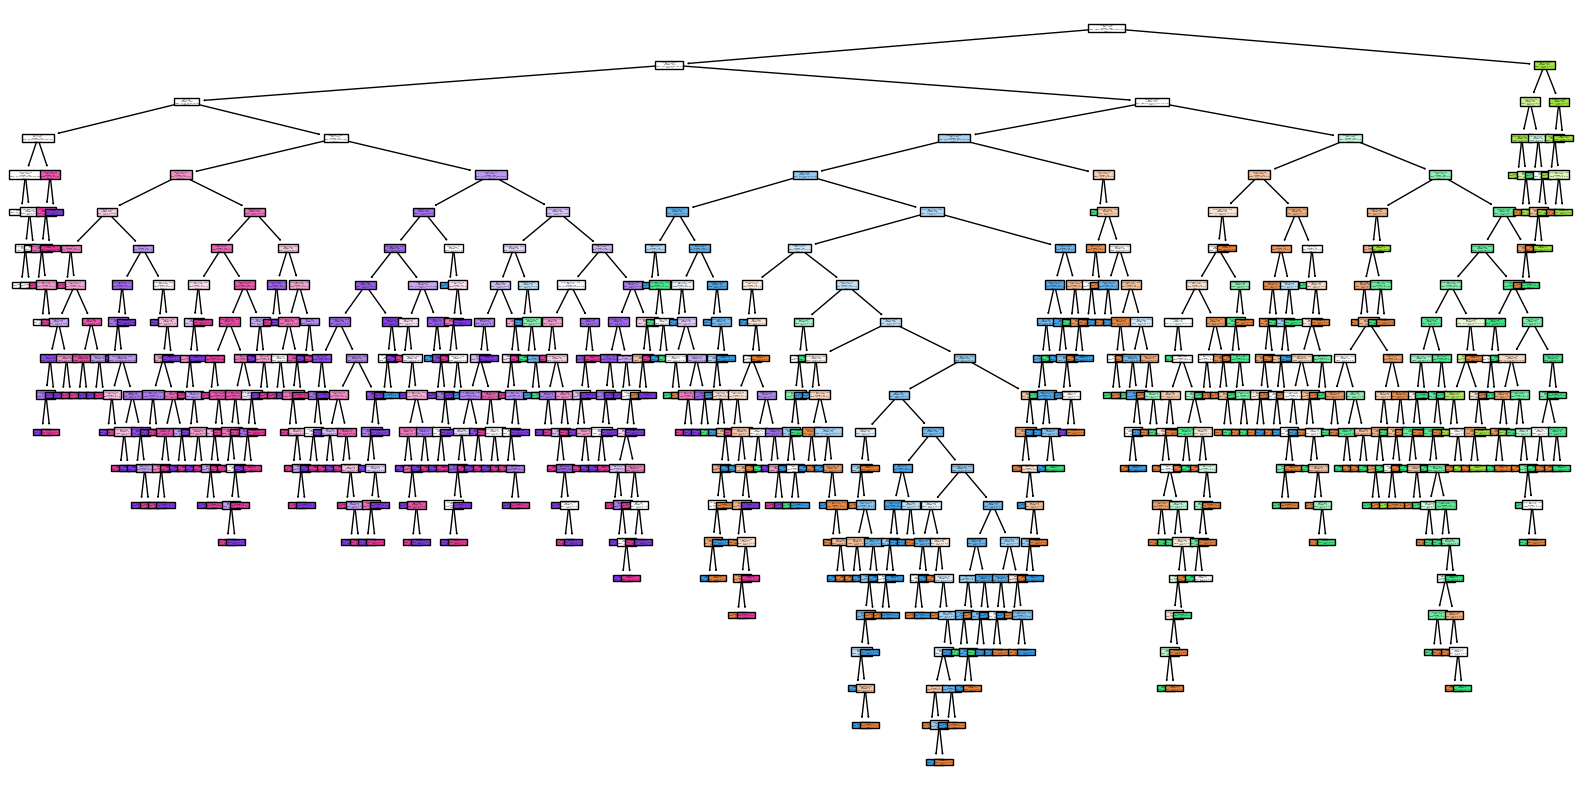

In [426]:
plt.figure(figsize=(20, 10))
plot_tree(dt, 
          filled=True, 
          feature_names=X.columns, 
          class_names=[str(label) for label in y.unique()])
plt.show()

### Explain briefly the question. What is the role of gini in decision tree? (10 points)



## Role of Gini in Decision Trees

- The **Gini Impurity** is used to measure the effectiveness of a **split**.
- The decision tree algorithm **chooses splits that minimize Gini Impurity**, aiming to create **pure nodes** (all samples belong to the same class). And does this using **entropy**.
- The tree continues splitting until a stopping criterion which is something like maximum depth or gini threshold met.

## Interpreting Gini Values

- **Gini = 0**: The node is **pure**, all samples belong to the same class.
- **Gini = 1**: The node is **impure**, samples are equally distributed across classes.
- **Lower Gini = Better**: The decision tree tries to minimize Gini to achieve purer nodes.

## Preventing Overfitting with Gini

Overfitting occurs when the decision tree becomes too complex and fits the noise in the training data. To prevent this, we can set a **Gini threshold** for example: Stop splitting if the Gini value is below a certain value (e.g., Gini < 0.1).

